# Percolation analysis (Assortativity)

* read a network
* drop the links
* add links based on some measure (for example, link weight)

* we measure on scale (0-1) how quickly they make a one complete component
* Percolation = |N_LCC|/|N|


In [1]:
import pandas as pd 
import networkx as nx
import os
import random
from random import sample

def read_graph(N):
    G = nx.Graph()
    return nx.read_gml(f'Networks/{N}.gml')

names = [ 'dolphins',
          'polbooks',
          'word_adjacencies',
          'arenas-email',
             'Karate',
             'Erdos Renyi',
             'circuits s208',
             'circuits s420',
             'circuits s838',
             'E. coli',
             'Barabasi_albert_graph',
             'facebook 0',
             'facebook 107',
             'facebook 348',
             'facebook 414',
             'facebook 686',
             'facebook 1684',
             'bn-macaque-rhesus_brain_2',
             'soc-tribes',
             'fb-pages-food',
             'bn-cat-mixed-species_brain_1',
             'soc-firm-hi-tech']


# read the networks
networks = []
for N in names:
    network = {}
    network['name'] = N
    network['graph'] = read_graph(N)
    networks.append(network)
networks

In [3]:
nodes = [len(n['graph'].nodes()) for n in networks]
edges = [len(n['graph'].edges()) for n in networks]

pd.DataFrame({'Names': names, '$|N|$': nodes, '$|E|$': edges})

,Names,$|N|$,$|E|$
0,dolphins,62,159
1,polbooks,190,441
2,word_adjacencies,112,425
3,arenas-email,1893,5451
4,Karate,34,78
5,Erdos Renyi,500,1500
6,circuits s208,122,189
7,circuits s420,252,399
8,circuits s838,512,819
9,E. Coli,1699,3758


In [4]:
def properties(G):
    
    GCC = nx.transitivity(G)
    ACC = nx.average_clustering(G)
    d = nx.density(G)
    r = nx.degree_assortativity_coefficient(G)    
    lcg = sorted(nx.connected_components(G), key=len, reverse=True)
    LCG = G.subgraph(lcg[0])    
    ASP = nx.average_shortest_path_length(LCG)
    diam = nx.diameter(LCG)

    communities = greedy_modularity_communities(G)
    mod = nx.community.modularity(G, communities)
    eff = round(nx.global_efficiency(G), 12)
    return  GCC, ACC, d, r, ASP, diam, mod, eff

In [5]:
def weighted_edges(G, C):
    '''return a weighted edges'''
    W = []
    for u,v in G.edges():
        W.append([u, v, C[u]*C[v]])
    return sorted(W, key=lambda x: x[2])

def batch_list(lst):
    """
    Divide a list into batches of an equal number of items (as close to 50 as possible).
    """
    batch_size = (len(lst) + 49) // 50  # Calculate the batch size
    num_batches = (len(lst) + batch_size - 1) // batch_size
    batches = [lst[i*batch_size:(i+1)*batch_size] for i in range(num_batches)]
    return batches

def simulation(centr):
    results = []
    for n in networks:
#         _=input(n['name'])
        G = n['graph'].copy()
        bc_G = centr(G)
        W = weighted_edges(G, bc_G)
        batches = batch_list(W)
#         print(f'number of batches = {len(batches)}')
        result = []
        for b in range(len(batches)):
            R = [(u,v) for u,v,_ in batches[b]] # edges to be removed...
            G.remove_edges_from(R)
            r = nx.degree_assortativity_coefficient(G)  
            result.append([b,r] )
#         print(result)
        results.append(result)
    return results

In [6]:
def plot(results, title):
    import matplotlib.pyplot as plt
    fig = plt.figure(dpi=600)
    fig, ax = plt.subplots()
    markers = ['+', 'x', 'o', 's', 'd', 'D', '*'] # Add your desired markers here
    for d in range(len(results)):
        data = results[d]
        x = [item[0] for item in data]
        y = [item[1] for item in data]
        marker_idx = d % len(markers) # Choose marker based on index of the result
        ax.plot(x, y, marker=markers[marker_idx], linewidth=0.5, markersize=3, label=names[d])

    ax.set_xlabel('edges')
    ax.set_ylabel(r'$r$')
    ax.set_title(f'{title}-based weighted edges')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


/home/almusawiaf/anaconda3/lib/python3.9/site-packages/networkx/algorithms/assortativity/mixing.py:208: RuntimeWarning: invalid value encountered in true_divide
  a = a / a.sum()
/home/almusawiaf/anaconda3/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


<Figure size 3840x2880 with 0 Axes>

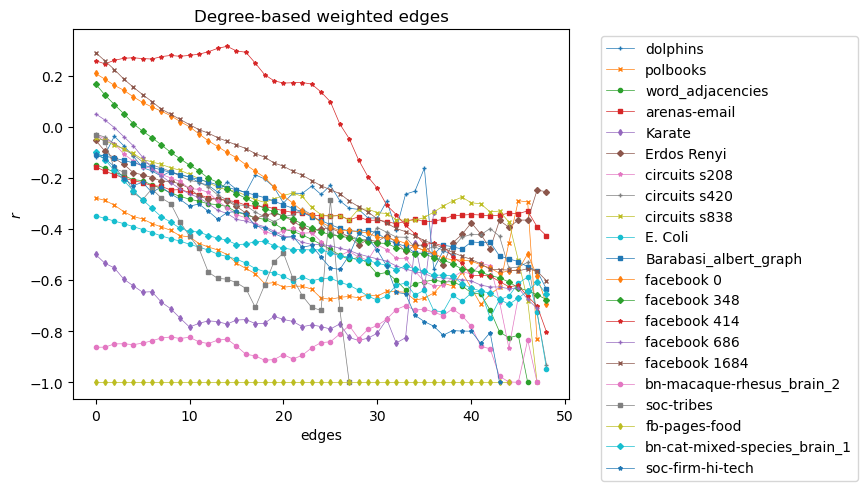

<Figure size 3840x2880 with 0 Axes>

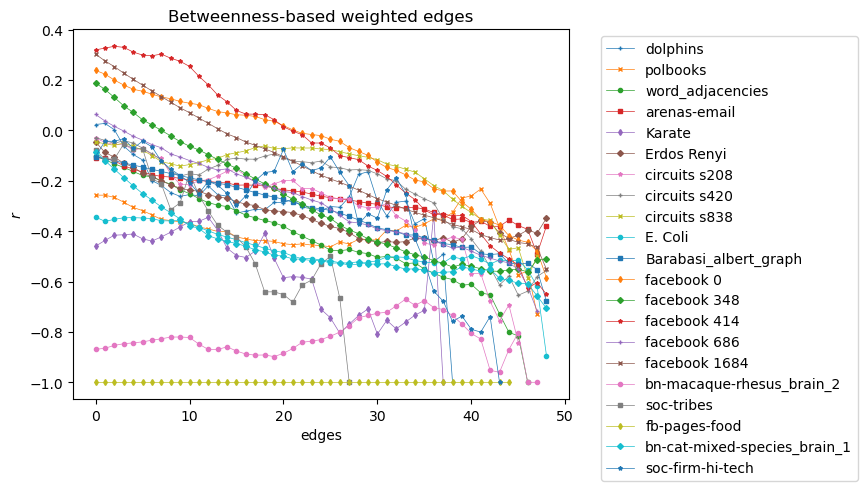

<Figure size 3840x2880 with 0 Axes>

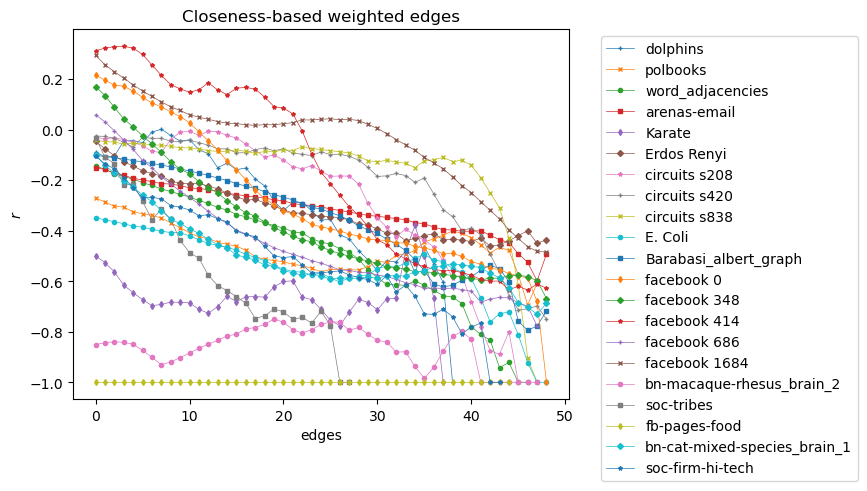

<Figure size 3840x2880 with 0 Axes>

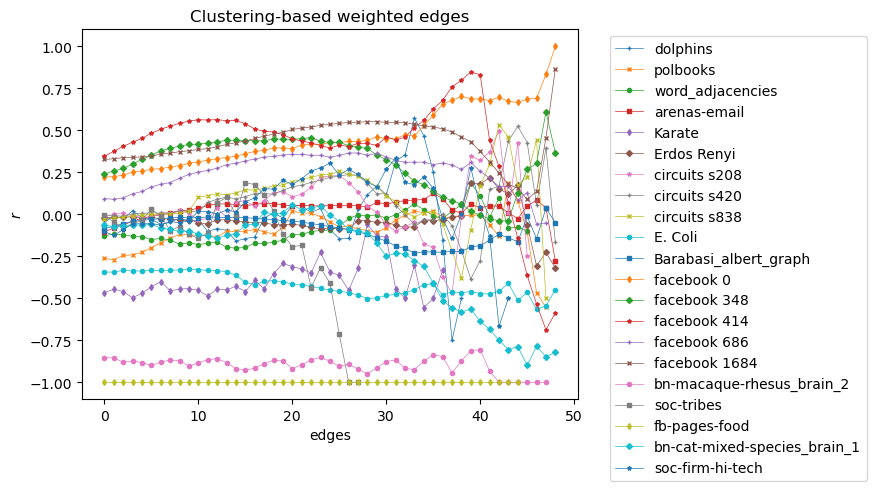

In [7]:
centralities = [nx.degree_centrality, nx.betweenness_centrality, nx.closeness_centrality, nx.clustering]
centr        = ['Degree'            ,   'Betweenness'          ,   'Closeness'          ,   'Clustering']
for i in range(4):
    plot(simulation(centralities[i]), centr[i])

In [55]:

import random

def LCC(G):
    connected_components = list(nx.connected_components(G))
    if len(connected_components) > 0:
        subG = G.subgraph(max(connected_components, key=len))
        if len(subG.nodes())>1: 
            return subG
        else:
            return None
    else:
        # Handle the case when there are no connected components
        return None

def node_robustness(G):
    N = len(G.nodes())
    if N==0:
        return 0
    else:
        t = []
        G2 = nx.Graph()
        G2 = G.copy()
        for q in range(N):
            d = q * len(G2.nodes())
            D = random.sample(G2.nodes(), d)
            G2.remove_nodes_from(D)
            lcc = LCC(G2)
            if lcc:
                t.append(len(LCC(G2).nodes()))
        return sum(t)/N

def edge_robustness(G):
    E = len(G.edges())
    if E == 0:
        return 0
    else:
        t = []
        G2 = nx.Graph()
        G2 = G.copy()
        for q in range(E):
            d = q * len(G2.edges())
            D = random.sample(G2.edges(), d)
            G2.remove_edges_from(D)
            lcc = LCC(G2)
            if lcc:
                t.append(len(LCC(G2).edges()))
        # print(t)
        return sum(t)/E
    

def nodes_centrality(G, C):
    '''return a weighted nodes'''
    W = []
    for u in G.nodes():
        W.append([u, C[u]])
    return sorted(W, key=lambda x: x[1], reverse=True)

def simulation2():
    finaln = {}
    finale = {}
    for i, c in enumerate(centralities):
        cent = centr[i]
        print(cent)
        resultsn = {}
        resultse = {}
        for perc in [0.1,0.2,0.3,0.4,0.5]:
            sub_resultsn = []
            sub_resultse = []
            for g in networks:
                G = g['graph'].copy()
                C = c(G)                          # finding the centrality of the nodes
                W = nodes_centrality(G, C)              # node's centrality
                N = round(len(W) * perc)                  # number of edges to be removed 
                nodes_to_remove = []
                for u, _ in W[:N]:
                    if u not in nodes_to_remove:
                        nodes_to_remove.append(u)
                    if v not in nodes_to_remove:
                        nodes_to_remove.append(v)

                print(len(G.nodes()))
                G.remove_nodes_from(nodes_to_remove)
                sub_resultsn.append(node_robustness(G))
                sub_resultse.append(edge_robustness(G))
                
            resultsn[f'{perc}'] = sum(sub_resultsn)/len(sub_resultsn)
            resultse[f'{perc}'] = sum(sub_resultse)/len(sub_resultse)
        finaln[cent] = resultsn
        finale[cent] = resultse
    return finaln, finale

datan, datae = simulation2()

Degree
62
190
112
1893


/tmp/ipykernel_24286/3499103860.py:25: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  D = random.sample(G2.nodes(), d)
/tmp/ipykernel_24286/3499103860.py:42: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  D = random.sample(G2.edges(), d)


34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
Betweenness
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
Closeness
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112
1893
34
500
122
252
512
1699
500
333
224
150
168
786
102
16
458
130
33
62
190
112

In [56]:
datan

{'Degree': {'0.1': 0.7669734983447176,
  '0.2': 0.6558006359364295,
  '0.3': 0.47487637561650153,
  '0.4': 0.35102579819068735,
  '0.5': 0.2736055837180371},
 'Betweenness': {'0.1': 0.7875775693369403,
  '0.2': 0.5553951739342953,
  '0.3': 0.43350466732292064,
  '0.4': 0.3302924763670375,
  '0.5': 0.22095508974003314},
 'Closeness': {'0.1': 0.8759936056312144,
  '0.2': 0.7463225159489182,
  '0.3': 0.6695836785518484,
  '0.4': 0.5220471055751286,
  '0.5': 0.4251201718840132},
 'Clustering': {'0.1': 0.9414755799776635,
  '0.2': 0.8898516944887181,
  '0.3': 0.8378360698862424,
  '0.4': 0.8259829442124336,
  '0.5': 0.7940295209983629}}

In [60]:
results = {}
for f in datae:
    print(f)
    P, V = [],[]
    for p in datae[f]:
        P.append(p)
        V.append(datae[f][p])
    results['Percentage'] = P
    results[f] = V

data = pd.DataFrame(results)
data


Degree
Betweenness
Closeness
Clustering


,Percentage,Degree,Betweenness,Closeness,Clustering
0,0.1,0.844592,0.873202,0.931405,0.950366
1,0.2,0.734592,0.632312,0.821174,0.902115
2,0.3,0.564550,0.535892,0.766723,0.867690
3,0.4,0.445836,0.447365,0.674988,0.887428
4,0.5,0.418271,0.341942,0.616101,0.874045


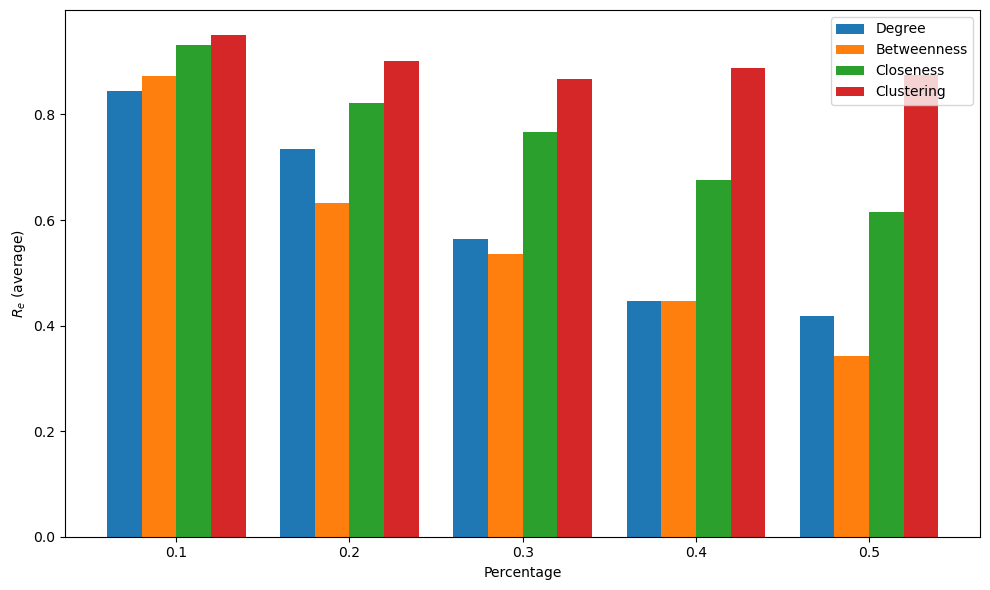

In [62]:
import matplotlib.pyplot as plt
import numpy as np


# Convert data to numpy arrays
x = np.arange(len(data['Percentage']))
width = 0.2

# Plotting
plt.figure(figsize=(10, 6))

# Degree
plt.bar(x, data['Degree'], width, label='Degree')

# Betweenness
plt.bar(x + width, data['Betweenness'], width, label='Betweenness')

# Closeness
plt.bar(x + (2 * width), data['Closeness'], width, label='Closeness')

# Clustering
plt.bar(x + (3 * width), data['Clustering'], width, label='Clustering')

plt.xlabel('Percentage')
plt.ylabel('$R_e$ (average)')
plt.xticks(x + (1.5 * width), data['Percentage'])
plt.legend()

plt.tight_layout()
plt.show()
